<a href="https://colab.research.google.com/github/Sushiman31/NLP_toxic/blob/main/CommentaireToxicSAUVAGE_BALDASSARRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [1]:
# from time import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import Tokenizer  
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split  

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# RNN & LSTM Imports
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [2]:
#on se connecte au google drive pour accéder au donné 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#on recupére les csv qui nous intéresse
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
test= pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test.csv')

# Etude du jeu de données

In [4]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


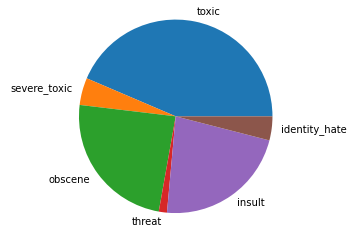

In [5]:
#on cherche a afficher la répartition des données 
your_data = {}
your_data["toxic"]=data['toxic'].sum()
your_data["severe_toxic"]=data['severe_toxic'].sum()
your_data["obscene"]=data['obscene'].sum()
your_data["threat"]=data['threat'].sum()
your_data["insult"]=data['insult'].sum()
your_data["identity_hate"]=data['identity_hate'].sum()

# Data to plot
labels = []
sizes = []

for x, y in your_data.items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels=labels)

plt.axis('equal')
plt.show()

In [6]:
#on calcule le nombre de commentaire toxic
nbr_comment_toxic=data["toxic"].sum()+data["severe_toxic"].sum()+data["obscene"].sum()+data["threat"].sum()+data["insult"].sum()+data["identity_hate"].sum()

In [7]:
data=data.drop('id',axis=1)#la colonne id n'est pas utile pour la prédiction
test=test.drop('id',axis=1)

In [8]:

nbr_comment_non_toxic=0
for i in range(len(data)):
  if ((data["toxic"][i] and data["severe_toxic"][i] and data["obscene"][i] and data["threat"][i] and data["insult"][i] and data["identity_hate"][i])==0):
    nbr_comment_non_toxic=nbr_comment_non_toxic +1

pourcentage_nbr_commentaire_non_toxic=(nbr_comment_non_toxic/(nbr_comment_non_toxic+nbr_comment_toxic))*100
print("il y a environ" ,pourcentage_nbr_commentaire_non_toxic ,"% de commentaire non toxic")
#il y a environ 80% de commentaire non toxic

#on remarque que la repartion entre les categori et non-équitable il faudra donc faire en sorte d'avoir une repartion équitable pour l'entrainement du réseau de neronne fin qui ne soit pas biaisé pas les probabilité
#certain commentaire coche plusieur categorie comme le 157718 mdata["toxic"].sum()+ais il sont sous representais donc nous pensons que le principal est qu'il soi au moin détecté mais pas forcement classé
#recall et F1-score AUC/ROC

il y a environ 81.967550015927 % de commentaire non toxic


In [9]:
#on ajoute les 'threat' vers les 'insulte'
for i in range(len(data)):
  if(data['threat'][i]==1 and data['insult'][i]==0):
    data['insult'][i]=1

<ipython-input-9-99f620eb0c41>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['insult'][i]=1


In [10]:
#on supprime la colonne 'threat'
data=data.drop('threat',axis=1)


In [11]:
data.head()

,comment_text,toxic,severe_toxic,obscene,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0


In [12]:
#création du label de prédiction 
label = data[['toxic', 'severe_toxic' , 'obscene'  , 'insult' , 'identity_hate']]
print(label.head())

   toxic  severe_toxic  obscene  insult  identity_hate
0      0             0        0       0              0
1      0             0        0       0              0
2      0             0        0       0              0
3      0             0        0       0              0
4      0             0        0       0              0


In [13]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet

In [14]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
#convertion des abreviations
def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [15]:
#on convertie les 'comment_text' en minuscules et on convertie les phrase en liste de mot 
data["comment_text"] = data["comment_text"].str.lower()
data["comment_text"] = data["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")
test["comment_text"] = test["comment_text"].str.lower()
test["comment_text"] = test["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

In [ ]:
#on met a bon format les données 
for i in range(len(data)):
  data["comment_text"][i]=clean(data["comment_text"][i])
  data["comment_text"][i]=convert_abbrev_in_text(data["comment_text"][i])
for i in range(len(test)):
  test["comment_text"][i]=clean(test["comment_text"][i])
  test["comment_text"][i]=convert_abbrev_in_text(test["comment_text"][i])

In [ ]:
#on cree un csv dans le drive pour notre trainning dataset et test dataset
data.to_csv('/content/drive/MyDrive/toxic.csv', index=False)

In [ ]:
test.to_csv('/content/drive/MyDrive/toxictest.csv', index=False)

In [16]:
# ouverture des dataset contenues dans le google drive 
DF = pd.read_csv('/content/drive/MyDrive/toxic.csv')
test=pd.read_csv('/content/drive/MyDrive/toxictest.csv')

In [17]:
#on recupaire les 'comment_text' dans une variable text
def return_tweets(df):
    texts=[]
    for index, item in df.drop(df.columns.difference(['comment_text']), axis=1).iterrows():
        message = item["comment_text"]
        texts.append(str(message))
    return texts

In [18]:
#creation des variable adapter au traitement du NN
text=return_tweets(DF)
text_test=return_tweets(test)

#Creation du modele

In [19]:
#tokenization des variables
tok = Tokenizer(num_words=1000, oov_token='UNK')
tok.fit_on_texts(text+text_test)


In [20]:
#on convertie en array le label 
y_train = np.asarray(label.values).astype('float32')

In [21]:
#nombre de mot en tout dans le test dataset et training dataset
vocab_inp_size = len(tok.word_index) + 1
print("Nombre de mot tokenizée :",vocab_inp_size)

Nombre de mot tokenizée : 408516


In [22]:
#on normalise notre jeu de donnée
x_train = tok.texts_to_sequences(text)
x_test = tok.texts_to_sequences(text_test)
# print(x_test)
training_padded = pad_sequences(x_train,
                                maxlen=50, 
                                truncating='post', 
                                padding='post'
                               )
# #tst_texts
test_padded = pad_sequences(x_test,
                            maxlen=50, 
                            truncating='post', 
                            padding='post'
                               )


tr_X, val_X, tr_y, val_y = train_test_split(training_padded, y_train, train_size=0.80, random_state=30)

In [23]:
#on regarde la dimension de nos variables
print(tr_X.shape)
print(tr_y.shape)
print(val_X.shape)
print(val_y.shape)

(127656, 50)
(127656, 5)
(31915, 50)
(31915, 5)


In [24]:
#implementation de reseaux de neuronne 
model_lstm = models.Sequential()
model_lstm.add(layers.Embedding(1000,128, input_length=50))
model_lstm.add(Bidirectional(layers.LSTM(32,activation='tanh')))
model_lstm.add(layers.Dense(256,activation='relu'))
model_lstm.add(layers.Dense(128,activation='relu'))
model_lstm.add(layers.Dense(5, activation='sigmoid'))

In [25]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           128000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 219,397
Trainable params: 219,397
Non-trainable params: 0
__________________________________________________

In [26]:
pip install tfa-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


In [27]:
#compilation et entrainment du model
import tensorflow_addons as tfa
f1 = tfa.metrics.F1Score(num_classes=5, average=None, threshold = 0.3)

model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC',f1])

history = model_lstm.fit(tr_X,
                    tr_y,
                    epochs=10,
                    validation_data=(val_X, val_y))

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


3990/3990 [==============================] - 96s 19ms/step - loss: 0.0836 - auc: 0.9465 - f1_score: 0.4812 - val_loss: 0.0758 - val_auc: 0.9536 - val_f1_score: 0.5291
Epoch 2/10
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0722 - auc: 0.9618 - f1_score: 0.5688 - val_loss: 0.0732 - val_auc: 0.9574 - val_f1_score: 0.6034
Epoch 3/10
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0688 - auc: 0.9660 - f1_score: 0.6148 - val_loss: 0.0733 - val_auc: 0.9608 - val_f1_score: 0.5976
Epoch 4/10
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0661 - auc: 0.9691 - f1_score: 0.6310 - val_loss: 0.0727 - val_auc: 0.9589 - val_f1_score: 0.6130
Epoch 5/10
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0635 - auc: 0.9723 - f1_score: 0.6452 - val_loss: 0.0731 - val_auc: 0.9590 - val_f1_score: 0.6085
Epoch 6/10
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0611 - auc: 0.9751 - f1_score: 0.6575 - v

# EVALUATION DU MODELE

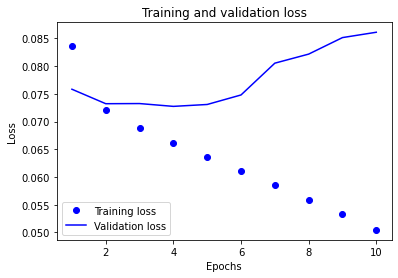

In [28]:
#presentation des metrics 
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [29]:
test_y = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test_labels.csv')

In [30]:
for i in range(len(test_y)):
  if(test_y['threat'][i]==-1 ):
    test_y['insult'][i]=1

<ipython-input-30-56a248d68864>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y['insult'][i]=1


In [31]:
for i in range(len(test_y)):
  if(test_y['toxic'][i]==-1 ):
    test_y['toxic'][i]=1
  if(test_y['severe_toxic'][i]==-1 ):
    test_y['severe_toxic'][i]=1
  if(test_y['obscene'][i]==-1 ):
    test_y['obscene'][i]=1
  if(test_y['threat'][i]==-1 ):
    test_y['threat'][i]=1
  if(test_y['insult'][i]==-1 ):
    test_y['insult'][i]=1
  if(test_y['identity_hate'][i]==-1 ):
    test_y['identity_hate'][i]=1

<ipython-input-31-305329766b95>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y['toxic'][i]=1
<ipython-input-31-305329766b95>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y['severe_toxic'][i]=1
<ipython-input-31-305329766b95>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y['obscene'][i]=1
<ipython-input-31-305329766b95>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [32]:
for i in range(len(test_y)):
  if(test_y['threat'][i]==1 and test_y['insult'][i]==0):
    test_y['insult'][i]=1

<ipython-input-32-fe62b39c44a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y['insult'][i]=1


In [33]:
test_y=test_y.drop('threat',axis=1)
test_y=test_y.drop('id',axis=1)

In [34]:
from tensorflow.keras.metrics import Precision
pre=Precision()
tf


<module 'tensorflow' from '/usr/local/lib/python3.8/dist-packages/tensorflow/__init__.py'>

In [35]:
for i in test_y:
  yhat=model_lstm.predict(test_padded)
  pre.update_state(test_y,yhat)

4787/4787 [==============================] - 17s 4ms/step


In [36]:
print(f'Precision:{pre.result().numpy()}')

Precision:0.8842951655387878


In [37]:
def pipeline(entry):
  text=[]
  text.append(entry)
  text[0]=clean(text[0])
  x=tok.texts_to_sequences(text)
  x_padded=pad_sequences(x,maxlen=50,truncating='post',padding='post')
  return model_lstm.predict(x_padded)


In [ ]:
pipeline("")